<a href="https://colab.research.google.com/github/shshwtsrkr/Automatic-License-Plate-Recognition/blob/main/alpr_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
gdir = '/content/drive/MyDrive/colab/'

In [3]:
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import keras
K = keras.backend
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from IPython.display import Image
import argparse
import os

In [4]:
test_dir = os.listdir(gdir + 'datasets/test_dataset/test_dataset/')

Import datasets

In [5]:
labels=pd.read_excel('/content/drive/MyDrive/colab/datasets/test_dataset/test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

,ID,NUMBER
0,1,KL55R2473
1,2,GJW115A1138
2,3,KL16J3636
3,4,MH20EE7598
4,5,PJJ1L76
...,...,...
181,182,DHF5B15
182,183,DBJ5R59
183,184,LVY8X45
184,185,YYD6B61


Contour detection

In [6]:
def eud(x1, x2, y1, y2):
  return ((x2-x1)**2 + (y2-y1)**2)**0.5

Functions used by YOLOv3

In [7]:
# Load names of classes, configuration and weights
class_file = gdir + "yolo_utils/classes.names";
model_config = gdir + "yolo_utils/darknet-yolov3.cfg";
model_weights = gdir + "yolo_utils/lapi.weights"

In [8]:
classes = None
conf_t = 0.5;
nms_t = 0.4;
inp_height, inp_width = 416, 416

# with - ensures ensures proper closure of the file after usage
# open(class_file, 'rt') - open the class_file in read mode
# assign the file to variable f
with open(class_file, 'rt') as f:

  # read() - read the entire document as string
  # rstrip() - remove all newlines from the string
  # split() - splits strings into substrings using newline as the delimiters
  classes = f.read().rstrip('\n').split('\n')

# load the pre-trained model from darknet framework 
net = cv2.dnn.readNetFromDarknet(model_config, model_weights)

# set preferable backend to implement the neural network
# basically we set preferable backend to perform the neural net computations, here OPENCV
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

# set the desired device on which the computations must be done
# cv2.dnn.DNN_TARGET_CPU - constant to use CPU as the target
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

print(net.getLayerNames()[226])
print(net.getUnconnectedOutLayers())

yolo_94
[200 227 254]


In [9]:
def output_layer_names(net):
  # get names of all layers
  op_layers = net.getLayerNames()

  # get names of output layers

  # Output layers are used for classification tasks, where the goal is to predict the class of an object. They have a single layer with a softmax activation function, which outputs a probability distribution over the 
  # Unconnected output layers are used for object detection tasks, where the goal is to predict the location and class of an object. They have two layers, the first of which outputs the coordinates of a bounding box, and the second of which outputs a probability distribution over the classes
  return [op_layers[i-1] for i in net.getUnconnectedOutLayers()]

In [10]:
def postprocess(frame, outs):
  # defining height and width of the frame
  frame_height = frame.shape[0]
  frame_width = frame.shape[1]

  class_ids = []
  confidences = []
  boxes = []

  for out in outs: # output layer values value for an image
    for detection in out: # one op layer value of an image

      # 5 onwards because :-
      # 0-4 (contains bounding box coordinates and other information for a detected object)
      # 0-3 : x & y co-ordinates (center), width, height
      # 4 : Class ID of the object (for LP : 1)
      # 5-9 : confidence score for each class, basically specifies the probability that the detected object in the image belongs to a specified class.

      scores = detection[5:] # contains confidence scores of each class
      class_id = np.argmax(scores) # returns the class ID of the class with highest confidence, tells what the detected object is (by highest confidence score)
      confidence = scores[class_id] # highest confidence score is stored

      if confidence > conf_t:
        center_x = int(detection[0] * frame_width)
        center_y = int(detection[1] * frame_height)
        width = int(detection[2] * frame_width)
        height = int(detection[3] * frame_height)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        class_ids.append(class_id) # serially stores class IDs of highest confidence in all layers in an image, for all images
        confidences.append(float(confidence)) # serially stores highest confidence in all layers in an image, for all images

        # print("Left :", left)
        # print("Top :", top)
        # print("Width :", width)
        # print("Height :", height)
        boxes.append([left, top, width, height])# coordinates according to all layers of an image, for all images
        # print("BOOOOOX : ",boxes)  

  processed=None
  indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_t, nms_t)
  for i in indices:
    i = i.item()
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
        
    # calculate bottom and right
    bottom = top + height
    right = left + width
        
    #crop the plate out
    processed = frame[top:bottom, left:right].copy()
    if processed is not None:
        return processed

In [11]:
#pred boxes
def find_contours(dims, img):

  # find all contours in the binary lp image
  cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # the potential dimensions
  lower_width = dims[0] # width/6
  upper_width = dims[1] # width/2
  lower_height = dims[2] # height/10
  upper_height = dims[3] # 2*height/3

  # sort the contours by area in descending order, top 15
  cntrs = sorted(cntrs, key = cv2.contourArea, reverse = True)[:15]

  im = cv2.imread('contour.jpg')

  x_cntr_list = []
  target_contours = []
  img_res = []

  for i in cntrs:

    # detects contour in binary image and returns the coordinates of rectangle enclosing it
    X, Y, Width, Height = cv2.boundingRect(i)

    # based on contour filter the characters by contour size
    if Width > lower_width and Width < upper_width and Height > lower_height and Height < upper_height:

      x_cntr_list.append(X) # store X coordinate of the character's contour
      char_c = np.zeros((44,24))

      # extract characters based on the rectangular coordinates
      char = img[Y:Y+Height, X:X+Width]
      char = cv2.resize(char, (20, 40))

      # take the extracted lp image and draw a rectangle with top-left and bottom right coordinates with () colors and thickness 2
      cv2.rectangle(im, (X, Y), (X+Width, Y+Height), (50,21,200), 2)

      plt.imshow(im, cmap='gray')
      plt.title('Predict Segments')

      # Make result formatted for classification: invert colors
      char = cv2.subtract(255, char)

      # resize the image to 24x44 
      char_c[2:42, 2:22] = char

      # black borders
      char_c[0:2, :] = 0
      char_c[:, 0:2] = 0
      char_c[42:44, :] = 0
      char_c[:, 22:24] = 0

      img_res.append(char_c) # list to stores character's binary image

  # arbitrary function that stores sorted list of character indices
  indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
  img_res_copy = []
  for idx in indices:
      img_res_copy.append(img_res[idx])# stores character images according to their index
  img_res = np.array(img_res_copy)

  return img_res

In [12]:
def character_segmentation(img):

  # if not isinstance(img, np.ndarray):
  #       raise ValueError("Input image must be a NumPy array.")
  # pre-process
  lp_img = cv2.resize(img, (333, 75)) # width x height
  gray_lp_img = cv2.cvtColor(lp_img, cv2.COLOR_BGR2GRAY)

  # thresholding the image to convert it to binary image
  # input image, threshold value, maximum value, cv2.THRESH_BINARY (white for above threshold) + optimize threshold value 
  _, binary_lp_img = cv2.threshold(gray_lp_img, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # cv2.erode() function works by taking the input image and the kernel, and then looping over each pixel in the input image. 
  # For each pixel, the function checks to see if all of the pixels under the kernel are the same color as the pixel. 
  # If they are, then the pixel in the output image is set to that color. 
  # Otherwise, the pixel in the output image is set to black
  # HELPS IN NOISE REMOVAL - by shrinking small objects
  # Isolating objects in an image
  # Thickening the edges of objects in an image
  binary_lp_img = cv2.erode(binary_lp_img, (3, 3))

  # For each pixel under the kernel, if any of the pixels are bright, then the pixel at the center of the kernel is set to bright. This process is repeated for every pixel in the image.
  # The dilated image is then returned
  # HELPS IN :-
  # Joining broken parts of an object in an image
  # Connecting adjacent objects in an image
  # Removing noise from an image
  binary_lp_img = cv2.dilate(binary_lp_img, (3, 3))

  width_lp = binary_lp_img.shape[0] # 75
  height_lp = binary_lp_img.shape[1] # 333
  
  # making borders white
  binary_lp_img[:, 0:3] = 255 # left border
  binary_lp_img[72:75, :] = 255 # bottom border
  binary_lp_img[0:3, :] = 255 # top border
  binary_lp_img[:, 330:333] = 255 # right border
  # plt.imshow(binary_lp_img)
  
  dims = [width_lp/6, width_lp/2, height_lp/10, 2*height_lp/3]
  plt.imshow(binary_lp_img, cmap = 'gray') # colormap
  plt.title('Contour')
  plt.show()
  cv2.imwrite('contour.jpg',binary_lp_img)

  char_list = find_contours(dims, binary_lp_img)

  return char_list

**Character Recognition** 

In [13]:
# # gdir + "yolo_utils/lapi.weights"
# aug_data = ImageDataGenerator(rescale= 1./255, width_shift_range=0.1, height_shift_range=0.1)
# path = gdir + "datasets/data"

# train_generator = aug_data.flow_from_directory(
#         path+'/train',  # this is the target directory
#         target_size=(28,28),  # all images will be resized to 28x28
#         batch_size=1,
#         class_mode='sparse')

# validation_generator = aug_data.flow_from_directory(
#         path+'/val',  # this is the target directory
#         target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
#         class_mode='sparse')

In [14]:
# K.clear_session()
# model = Sequential()
# model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(4, 4)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(36, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

In [15]:
# model.summary()

In [16]:
# batch_size = 1
# result = model.fit(
#       train_generator,
#       steps_per_epoch = train_generator.samples // batch_size,
#       validation_data = validation_generator, 
#       epochs = 25, verbose=1, callbacks=None)

In [17]:
# import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(14,5))
# grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
# fig.add_subplot(grid[0])
# plt.plot(result.history['accuracy'], label='training accuracy')
# plt.plot(result.history['val_accuracy'], label='val accuracy')
# plt.title('Accuracy')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.legend()

# fig.add_subplot(grid[1])
# plt.plot(result.history['loss'], label='training loss')
# plt.plot(result.history['val_loss'], label='val loss')
# plt.title('Loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()


In [18]:
# !mkdir /content/drive/MyDrive/colab/checkpoints

In [19]:
# model.save_weights(gdir + "checkpoints/cnn_i")

In [20]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights(gdir + 'checkpoints/cnn_i')

In [21]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results(count, row):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict(img)[0] #predicting the class
        y_ = np.argmax(y_)
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    print(plate_number)
    if plate_number==row:
        count+=1
    return count

# print(show_results())

Testing Block

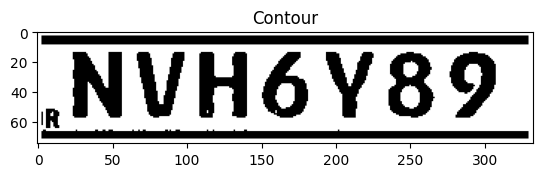

1/1 [==============================] - 0s 22ms/step
NVH6Y89
YOLO
Accuracy: 100.0%


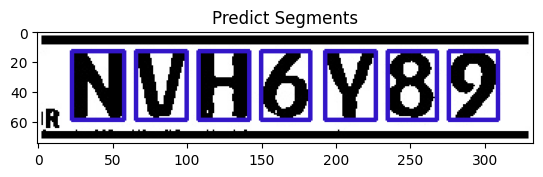

In [23]:
import matplotlib.pyplot as plt

test_img_dir = os.listdir( gdir + "datasets/test_dataset/test_dataset/images")
inp_img_path = gdir + 'datasets/test_dataset/test_dataset/images/' + '105.JPG'
path = '105.JPG'
is_video = False
no = path.split('.')
row = labels['NUMBER'].where(labels['ID'] == no[0]).dropna().values[0]
frame = cv2.imread(inp_img_path)

try:
  blob = cv2.dnn.blobFromImage(frame, 1/255, (inp_width, inp_height),[0,0,0], 1, crop=False)
except:
  exit(0)

net.setInput(blob)
outs = net.forward(output_layer_names(net)) # size is 3
processed = postprocess(frame, outs)
count = 0
if processed is not None:   
  timings, inf_time = net.getPerfProfile()
  perf_label = 'Inference time: %.2f ms' % (timings * 1000.0 / cv2.getTickFrequency())
  char=character_segmentation(processed)
  count=show_results(count, row)
  print("YOLO")
  print("Accuracy: "+str((count/1)*100)+"%")
  # print(plate)
else:
  ####
  image = cv2.imread(inp_img_path)
  # Resize the image - change width to 500
  image = imutils.resize(image, width=500)
  img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # RGB to Gray scale conversion
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Noise removal with iterative bilateral filter(removes noise while preserving edges)
  gray = cv2.bilateralFilter(gray, 11, 17, 17)

  # Find Edges of the grayscale image
  edged = cv2.Canny(gray, 170, 200)

  # Find contours based on Edges
  cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
  cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
  NumberPlateCnt = None #we currently have no Number plate contour

  # loop over our contours to find the best possible approximate contour of number plate
  for c in cnts:
          peri = cv2.arcLength(c, True)
          approx = cv2.approxPolyDP(c, 0.02 * peri, True)
          if len(approx) == 4:  # Select the contour with 4 corners
              NumberPlateCnt = approx #This is our approx Number Plate Contour
              x,y,w,h = cv2.boundingRect(c)
              ROI = img[y:y+h, x:x+w]
              break

  idx=0
  m=0
  # if NumberPlateCnt is None:
  #     continue
  for i in range(4):
      if NumberPlateCnt[i][0][1]>m:
          idx=i
          m=NumberPlateCnt[i][0][1]
  if idx==0:
      pin=3
  else:
      pin=idx-1
  if idx==3:
      nin=0
  else:
      nin=idx+1

  p=eud(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
  n=eud(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

  if p>n:
      if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
          left=pin
          right=idx
      else:
          left=idx
          right=pin
      d=p
  else:
      if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
          left=nin
          right=idx
      else:
          left=idx
          right=nin
      d=n
  left_x=NumberPlateCnt[left][0][0]
  left_y=NumberPlateCnt[left][0][1]
  right_x=NumberPlateCnt[right][0][0]
  right_y=NumberPlateCnt[right][0][1]

  opp=right_y-left_y
  hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
  sin=opp/hyp
  theta=math.asin(sin)*57.2958

  image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
  result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

  if opp>0:
      h=result.shape[0]-opp//2
  else:
      h=result.shape[0]+opp//2

  result=result[0:h, :]
  char=character_segmentation(result)
  count=show_results(count, row)
  print("CONTOUR")
  print("Accuracy: "+str((count/1)*100)+"%")

